# Cell area analysis

This notebook analyses all the areas of the detected cells and gets average cell size for the datasets

In [ ]:
import os
import sys
import json

import numpy as np
import pandas as pd
from PIL import Image
from typing import Optional
import matplotlib.pyplot as plt

### Definitions

In [ ]:
sys.path.insert(0, "../../")
from config import TEMP_PATH, CROPPED_PATH, RESULTS_PATH

# Paths
CROPS_PATH = os.path.join(CROPPED_PATH, 'ina', 'images')
OUTPUT_CSV_PATH = os.path.join(RESULTS_PATH, 'ina_sam_mask_areas.csv')
OUTPUT_JSON_PATH = os.path.join(TEMP_PATH, 'datasets_area_data.json')

data = []

In [ ]:
data = []

for image in os.listdir(CROPS_PATH):
    full_path = os.path.join(CROPS_PATH, image)

    try:
        with Image.open(full_path) as img:
            ancho, alto = img.size
            area = ancho * alto

            # Parse class, image_id, cell_id from filename
            name_without_ext = os.path.splitext(image)[0]
            parts = name_without_ext.split('_')
            if len(parts) == 3:
                image_class, image_id, cell_id = parts
            else:
                image_class, image_id, cell_id = (None, None, None)

            data.append({
                'nombre': image,
                'area_pixeles': area,
                'image_class': image_class,
                'image_id': image_id,
                'cell_id': cell_id
            })
    except Exception as e:
        print(f"Error processing {image}: {e}")

# Save to CSV
df = pd.DataFrame(data)
df.to_csv(OUTPUT_CSV_PATH, index=False)

print(f"✅ CSV saved to {OUTPUT_CSV_PATH}")



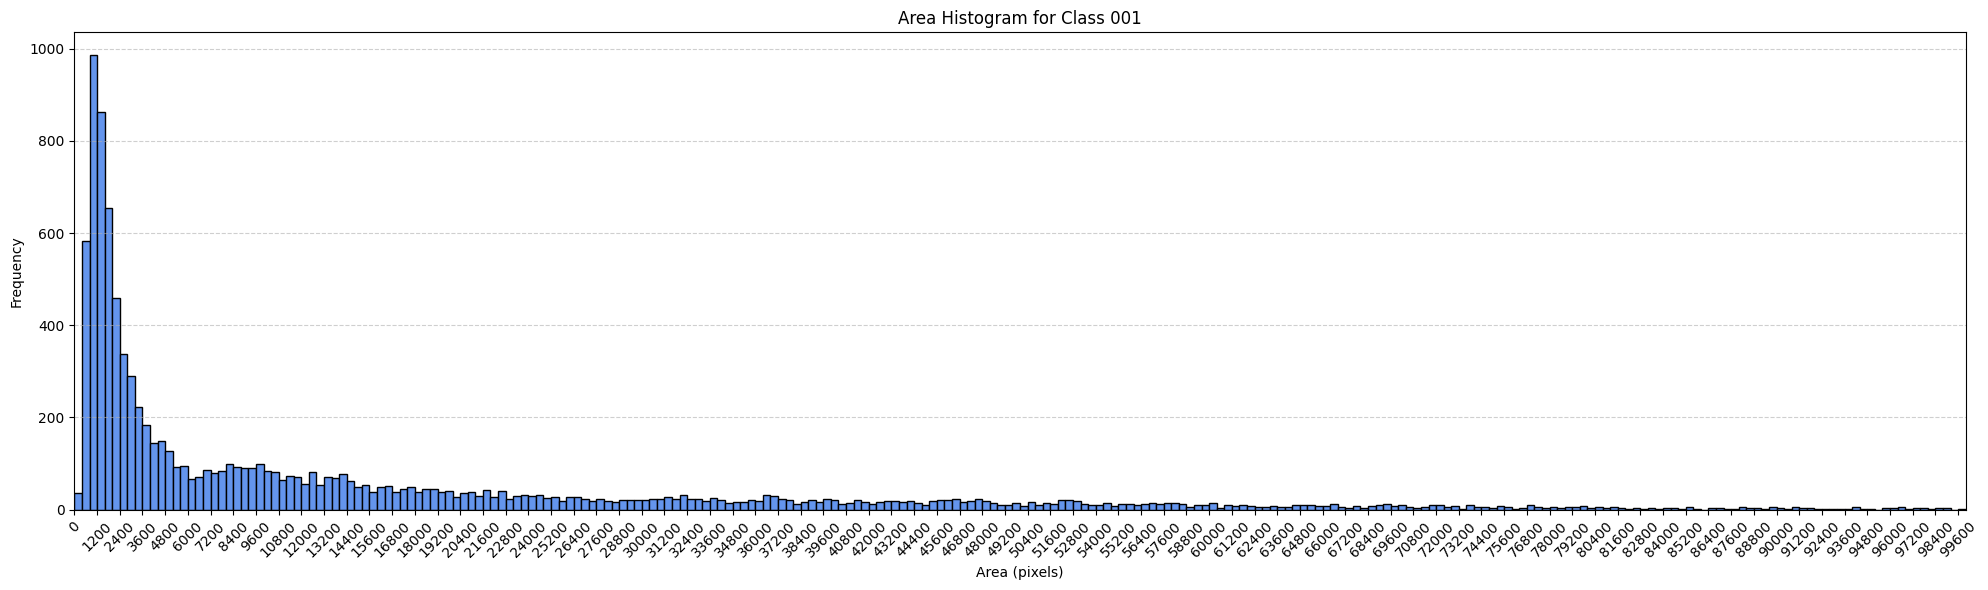

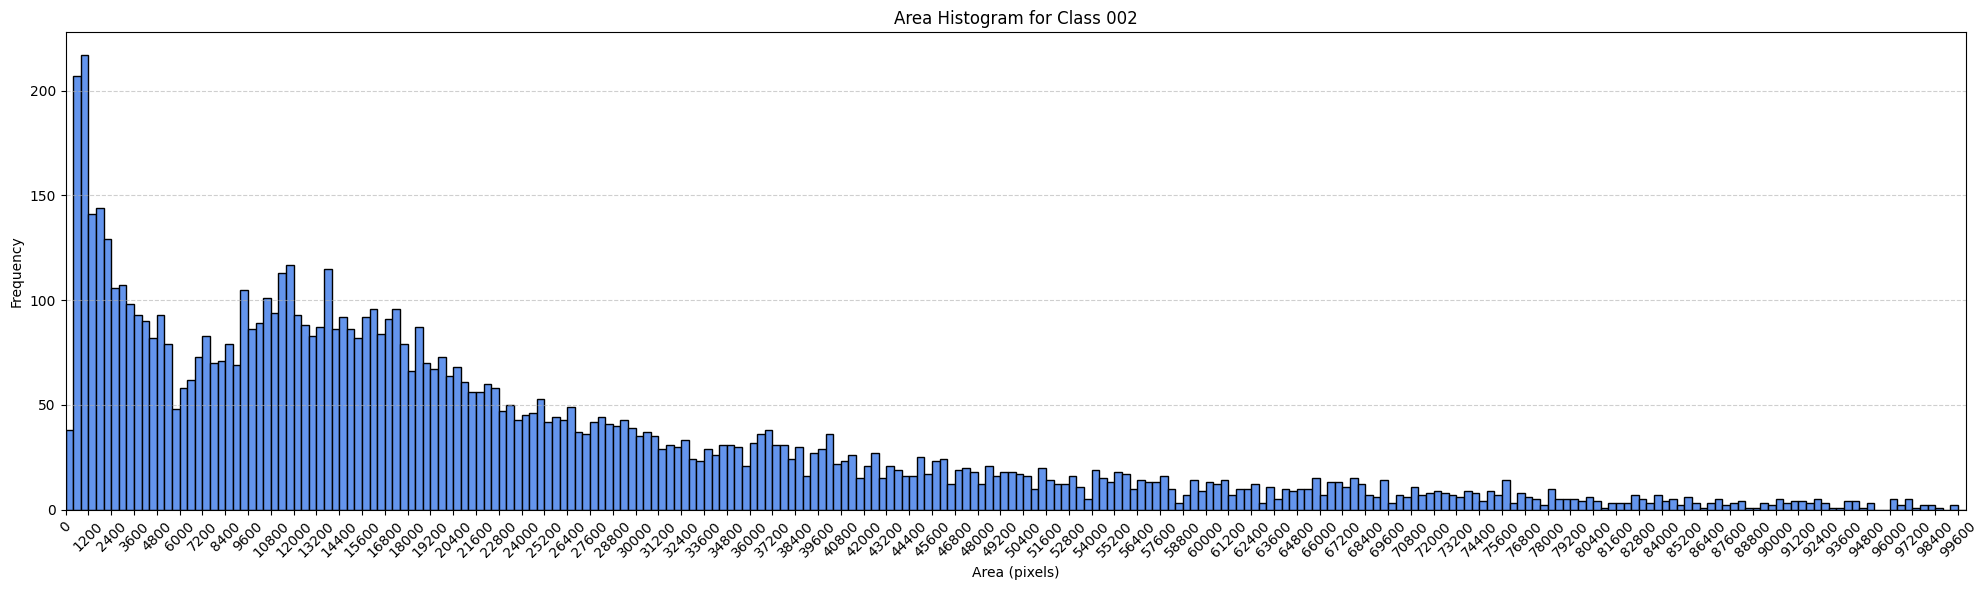

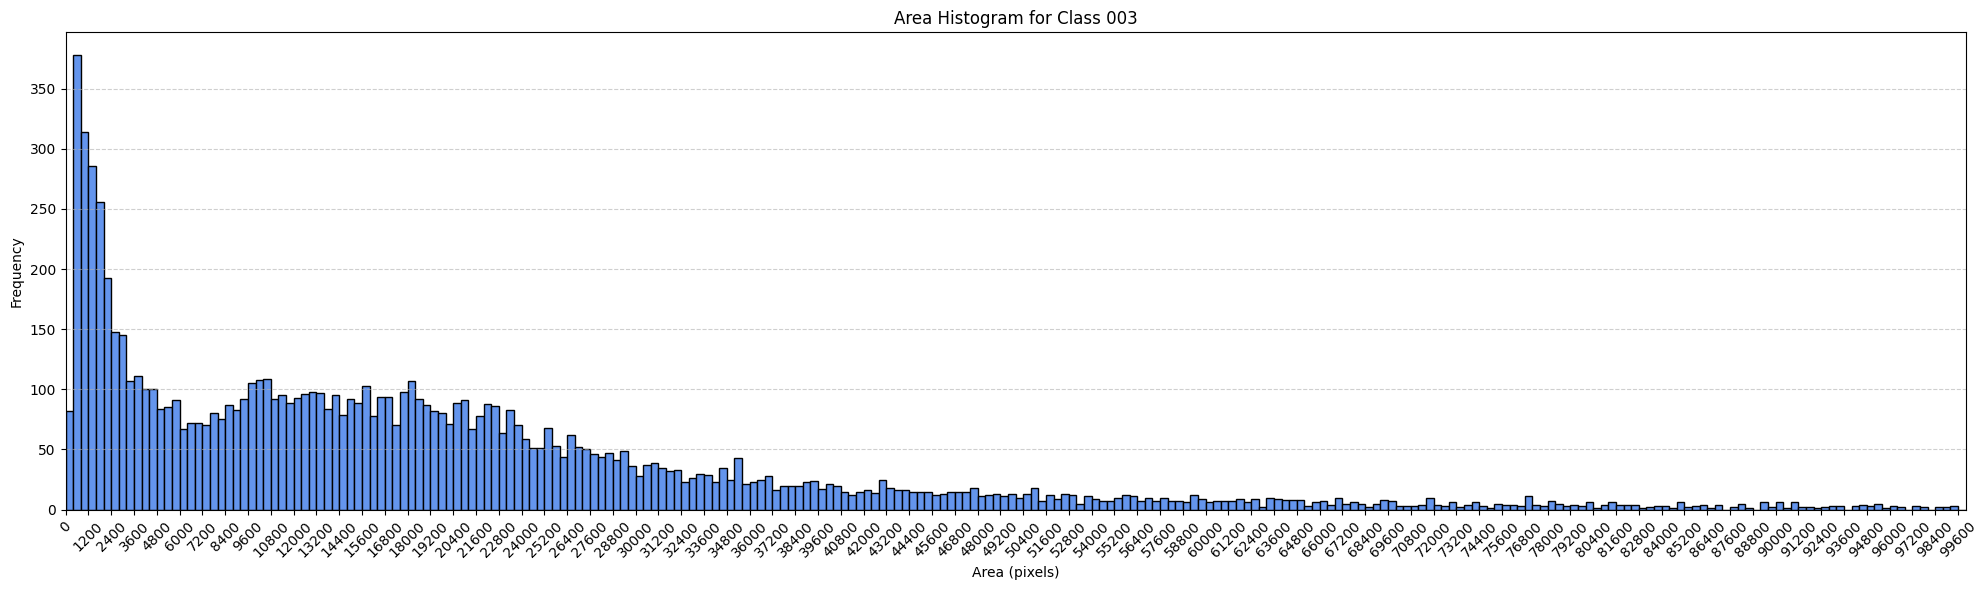

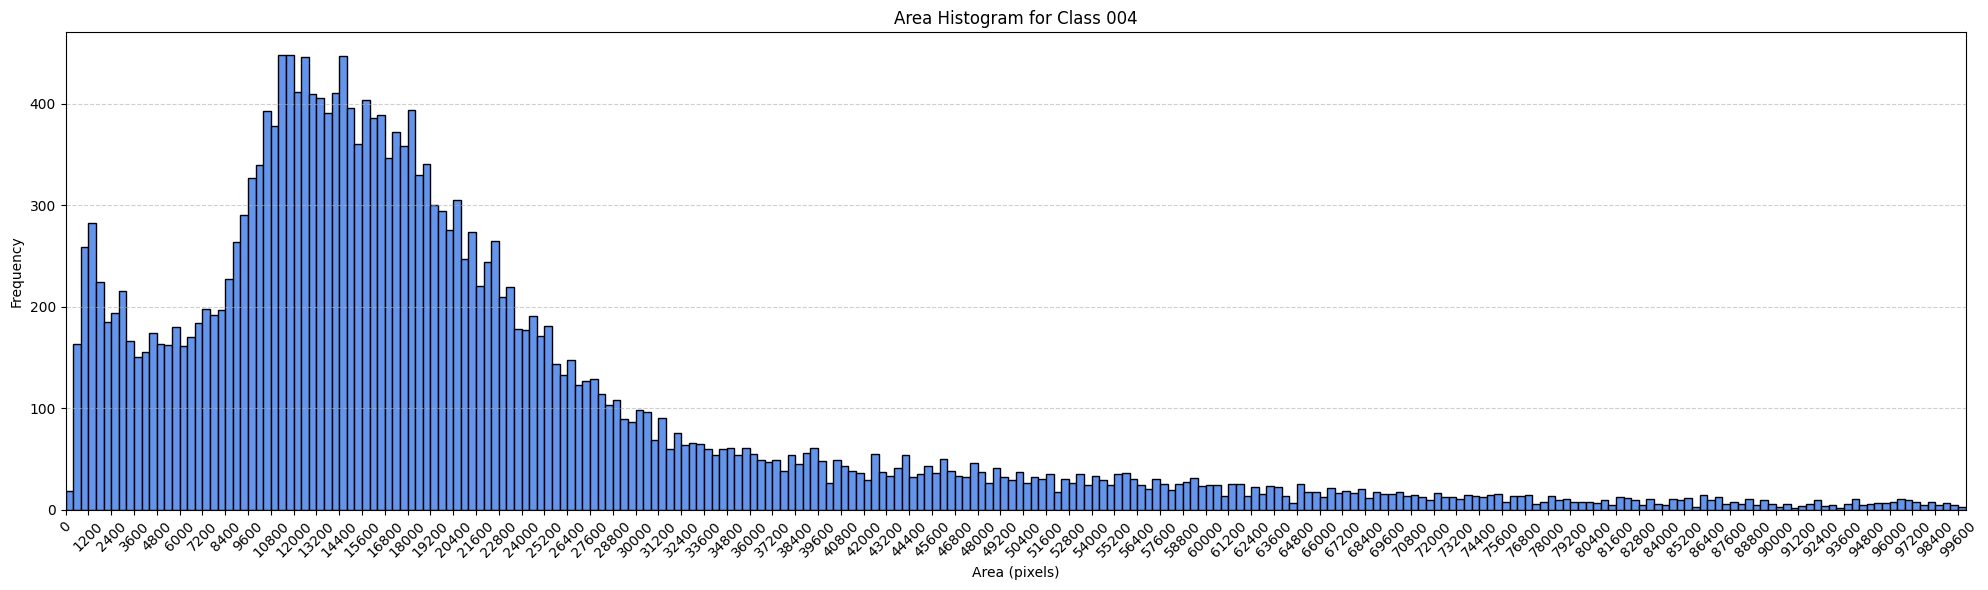

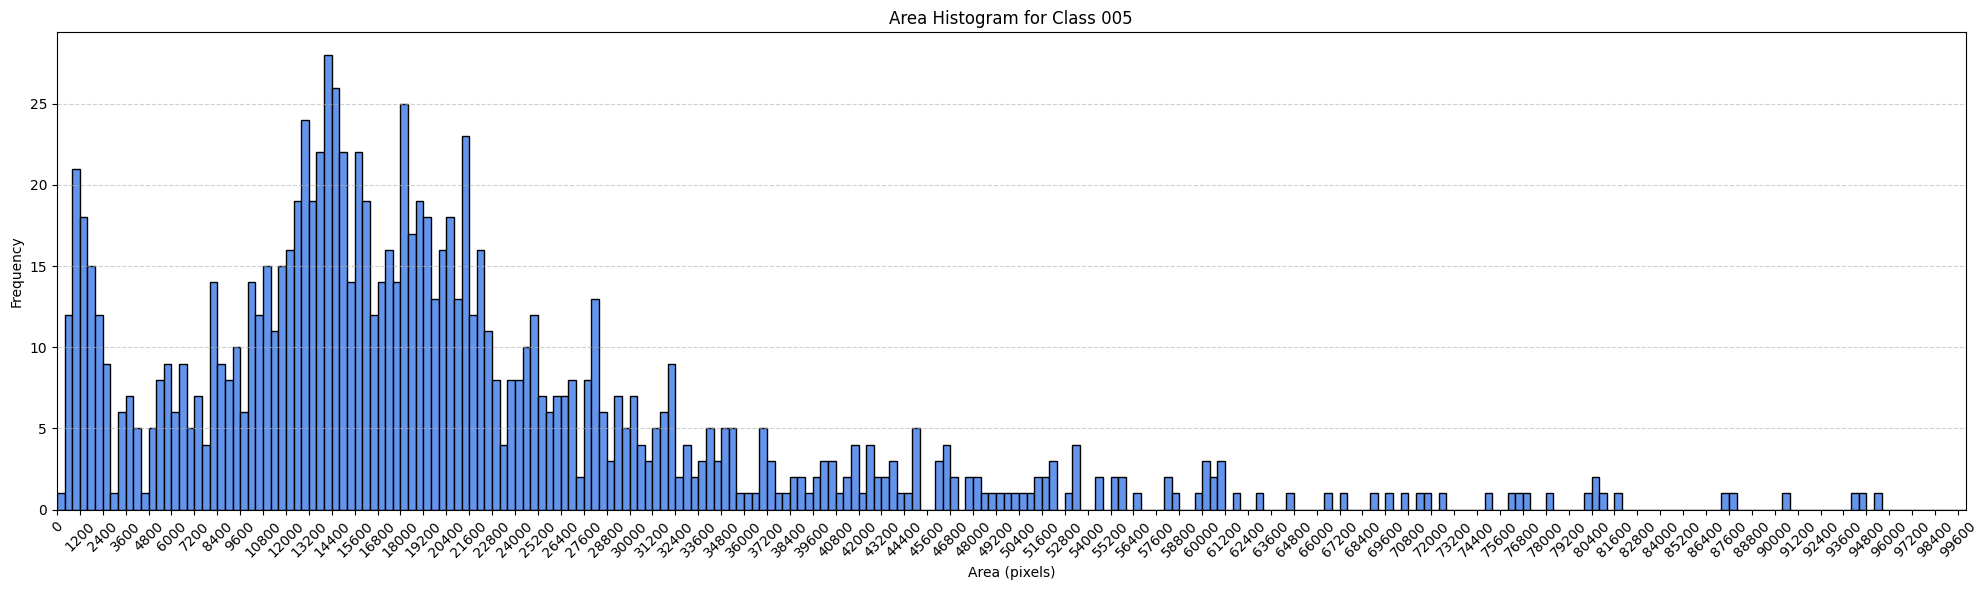

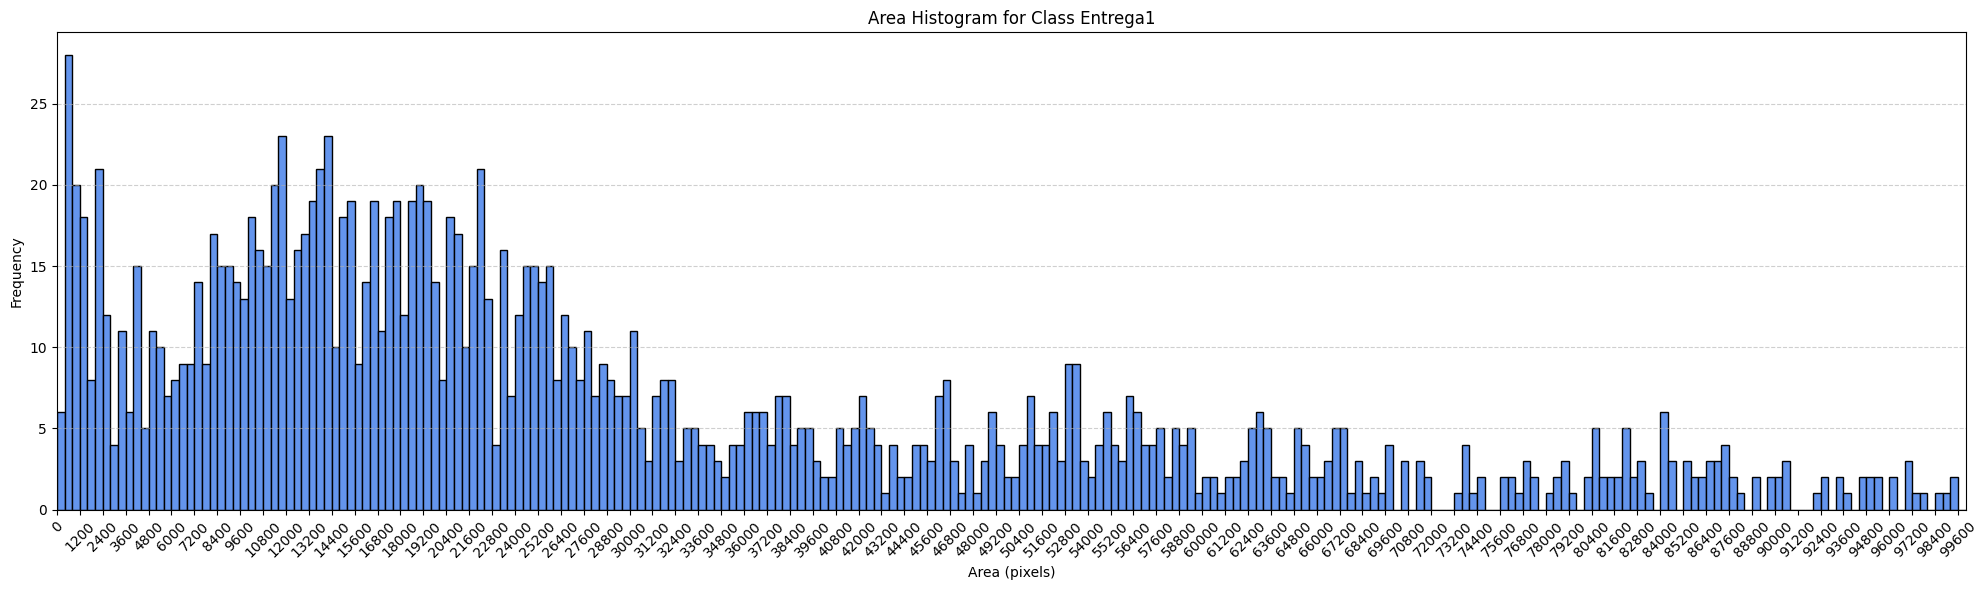

In [ ]:
# Set fixed bins and xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 3, bin_width * 3)

# Get unique classes
classes = sorted(df['image_class'].unique())

# Plot histograms for each class
for cls in classes:
    class_df = df[df['image_class'] == cls]
    
    plt.figure(figsize=(20, 6))
    plt.hist(class_df['area_pixeles'], bins=bins, color='cornflowerblue', edgecolor='black')
    plt.title(f"Area Histogram for Class {cls}")
    plt.xlabel("Area (pixels)")
    plt.ylabel("Frequency")
    plt.xticks(xticks, rotation=45)
    plt.xlim(bin_start, bin_end)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


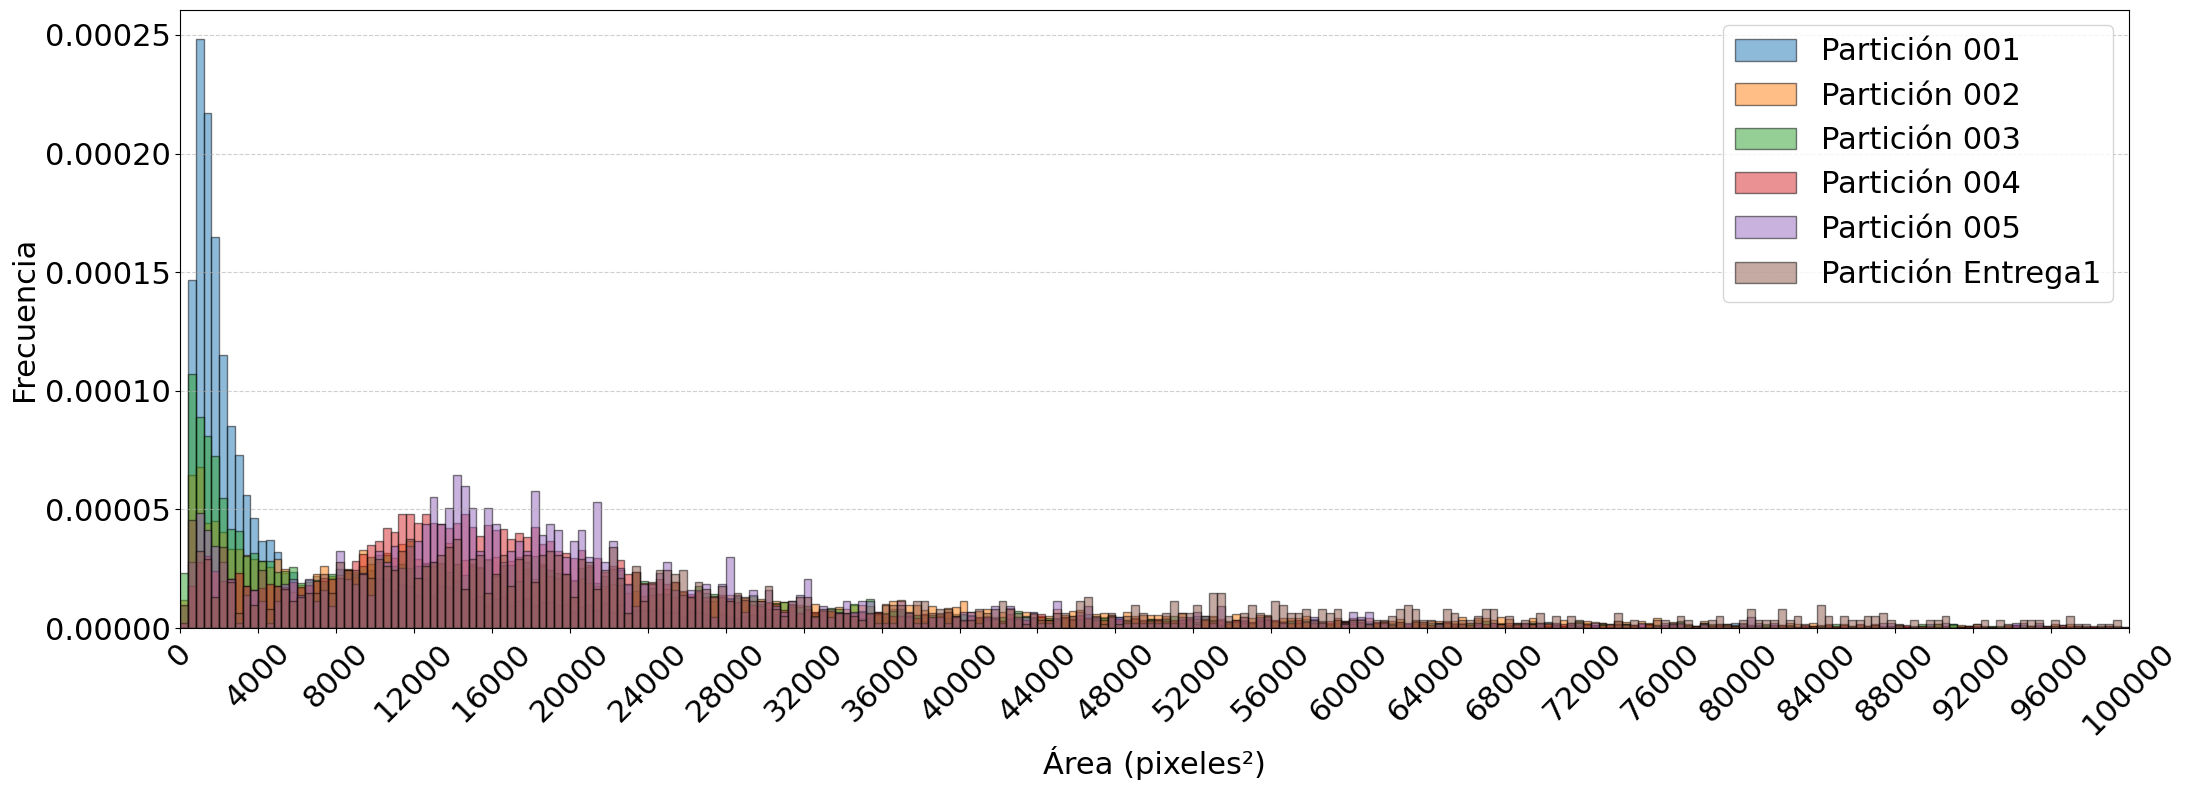

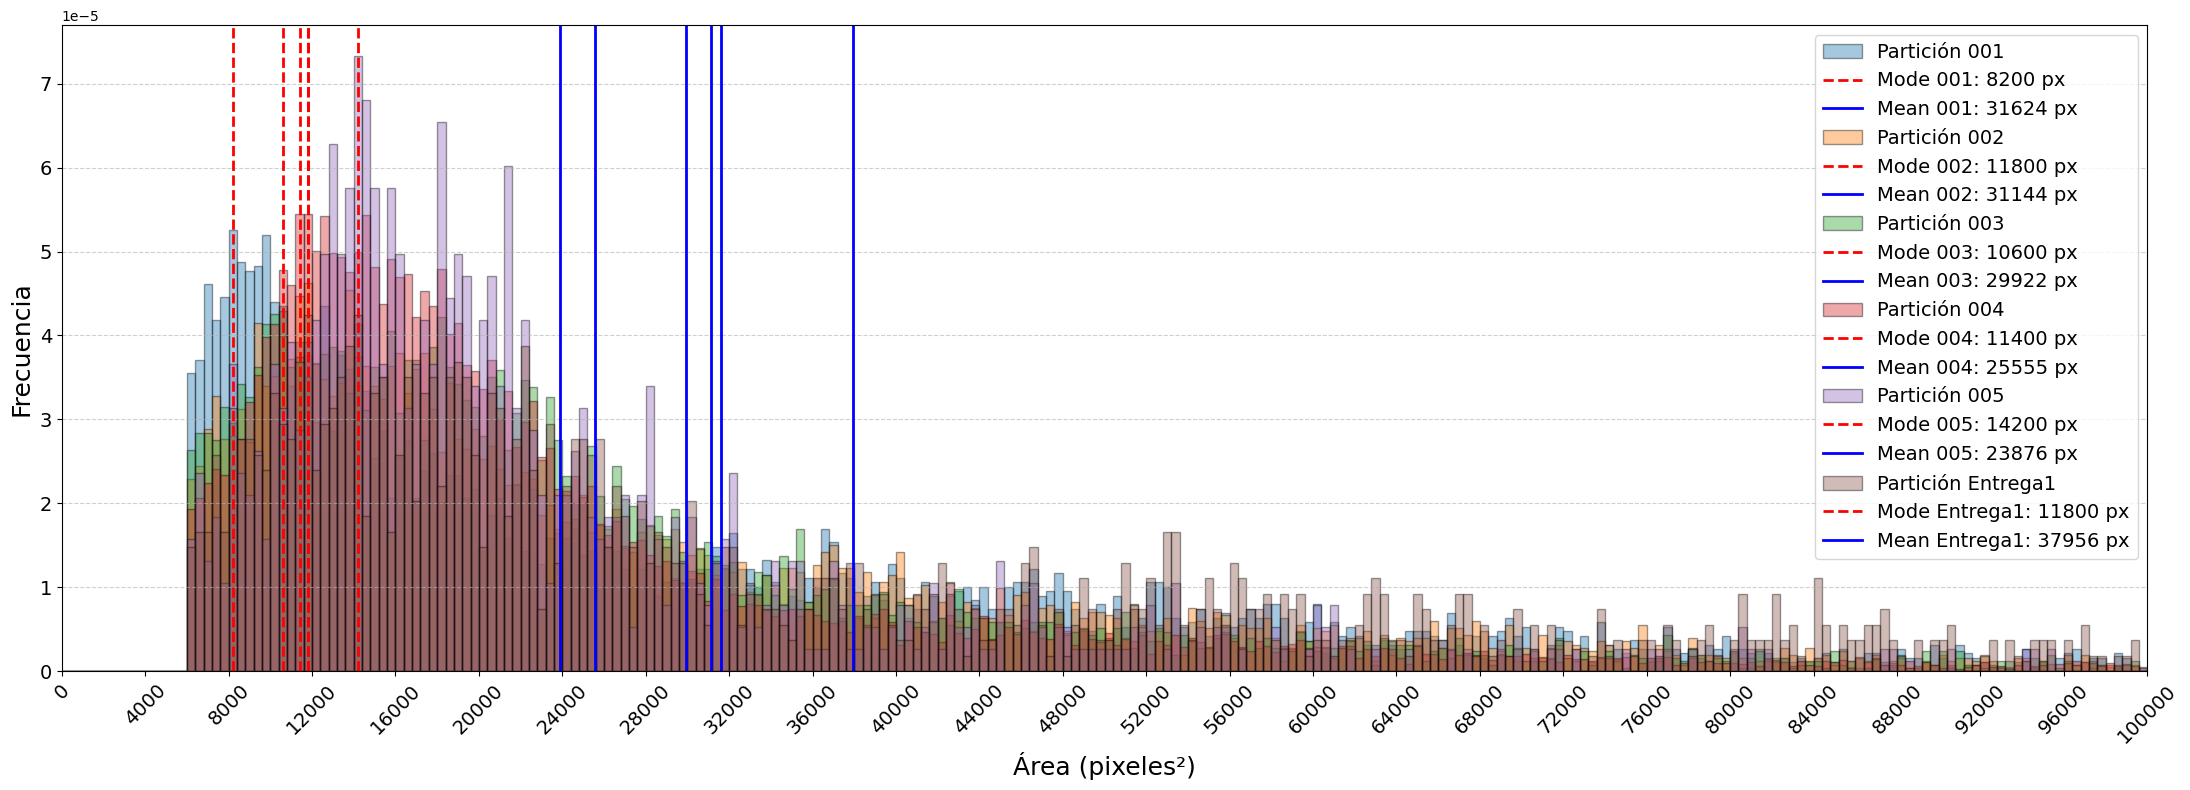

In [ ]:
# Filtered data
df_filtered = df[df['area_pixeles'] > 6000]

# Bins y xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 10, bin_width * 10)  # menos ticks

# Clases
classes = sorted(df['image_class'].unique())

# -------------------------------
# Plot 1: Normalized histograms (All Data)
plt.figure(figsize=(22, 8))
for cls in classes:
    class_df = df[df['image_class'] == cls]
    plt.hist(class_df['area_pixeles'], bins=bins, alpha=0.5, label=f'Partición {cls}',
             edgecolor='black', density=True)

plt.xlabel("Área (pixeles²)", fontsize=22)
plt.ylabel("Frecuencia", fontsize=22)
plt.xticks(xticks, rotation=45, fontsize=22)
plt.yticks(fontsize=22)
plt.xlim(bin_start, bin_end)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=22, loc='upper right')
plt.tight_layout()
plt.savefig('my_plot.jpg', dpi=800, format='jpg')
plt.show()

# -------------------------------
# Plot 2: Normalized histograms (Filtered data > 6000) con moda y media
plt.figure(figsize=(22, 8))

for cls in classes:
    class_df = df_filtered[df_filtered['image_class'] == cls]
    if len(class_df) < 5:
        continue

    # Histograma
    plt.hist(class_df['area_pixeles'], bins=bins, alpha=0.4, label=f'Partición {cls}',
             edgecolor='black', density=True)
    
    # Moda
    counts, edges = np.histogram(class_df['area_pixeles'], bins=bins, density=True)
    max_bin_idx = np.argmax(counts)
    mode_center = (edges[max_bin_idx] + edges[max_bin_idx + 1]) / 2
    plt.axvline(x=mode_center, linestyle='--', color='red', linewidth=2,
                label=f'Mode {cls}: {int(mode_center)} px')
    
    # Media
    mean_val = class_df['area_pixeles'].mean()
    plt.axvline(x=mean_val, linestyle='-', color='blue', linewidth=2,
                label=f'Mean {cls}: {int(mean_val)} px')

plt.xlabel("Área (pixeles²)", fontsize=18)
plt.ylabel("Frecuencia", fontsize=18)
plt.xticks(xticks, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(bin_start, bin_end)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
from dataclasses import dataclass, asdict

@dataclass
class AreaData:
    area_promedio: int
    lado_cuadrado: float
    diff_area: Optional[float] = None
    dif_lado: Optional[float] = None

partitions_data = {}

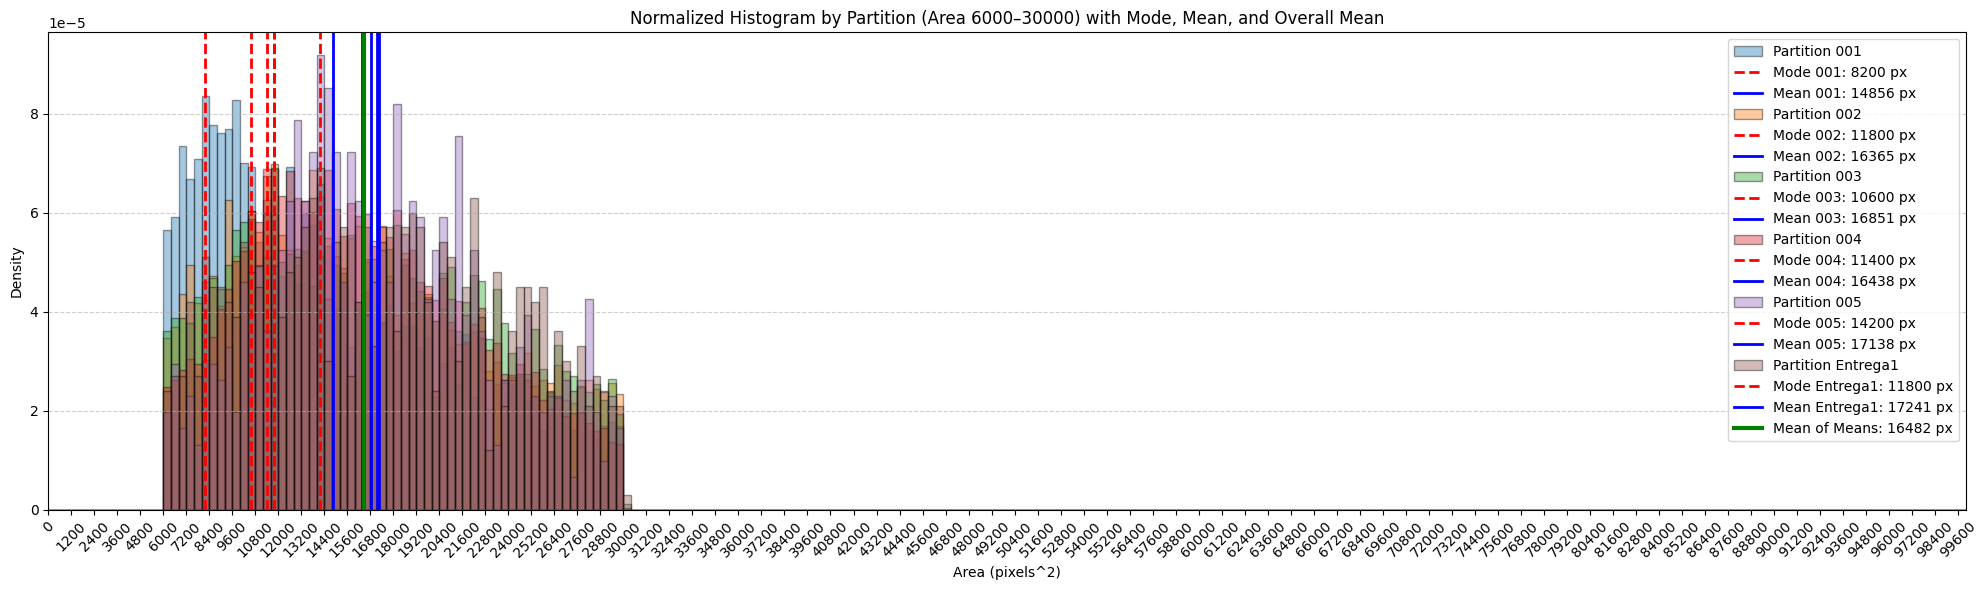

In [ ]:
# Filtered data
df_filtered = df[(df['area_pixeles'] >= 6000) & (df['area_pixeles'] <= 30000)]

# Set fixed bins and xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 3, bin_width * 3)

# Track means
class_means = []

# Plot: Normalized histograms (filtered data)
plt.figure(figsize=(20, 6))

for cls in classes:
    class_df = df_filtered[df_filtered['image_class'] == cls]
    if len(class_df) < 5:
        continue

    # Plot histogram
    plt.hist(class_df['area_pixeles'], bins=bins, alpha=0.4, label=f'Partition {cls}',
             edgecolor='black', density=True)

    # Mode (most frequent bin center)
    counts, edges = np.histogram(class_df['area_pixeles'], bins=bins, density=True)
    max_bin_idx = np.argmax(counts)
    mode_center = (edges[max_bin_idx] + edges[max_bin_idx + 1]) / 2
    plt.axvline(x=mode_center, linestyle='--', color='red', linewidth=2,
                label=f'Mode {cls}: {int(mode_center)} px')

    # Mean
    mean_val = class_df['area_pixeles'].mean()
    class_means.append(mean_val)
    plt.axvline(x=mean_val, linestyle='-', color='blue', linewidth=2,
                label=f'Mean {cls}: {int(mean_val)} px')

# Mean of class means
if class_means:
    mean_of_means = np.mean(class_means)
    plt.axvline(x=mean_of_means, linestyle='-', color='green', linewidth=3,
                label=f'Mean of Means: {int(mean_of_means)} px')

plt.title("Normalized Histogram by Partition (Area 6000–30000) with Mode, Mean, and Overall Mean")
plt.xlabel("Area (pixels^2)")
plt.ylabel("Density")
plt.xticks(xticks, rotation=45)
plt.xlim(bin_start, bin_end)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()




In [29]:

partitions_data['ina_sam'] = AreaData(
                                        area_promedio = mean_of_means,
                                        lado_cuadrado = np.sqrt(mean_of_means),
                                        diff_area = None,
                                        dif_lado = None)

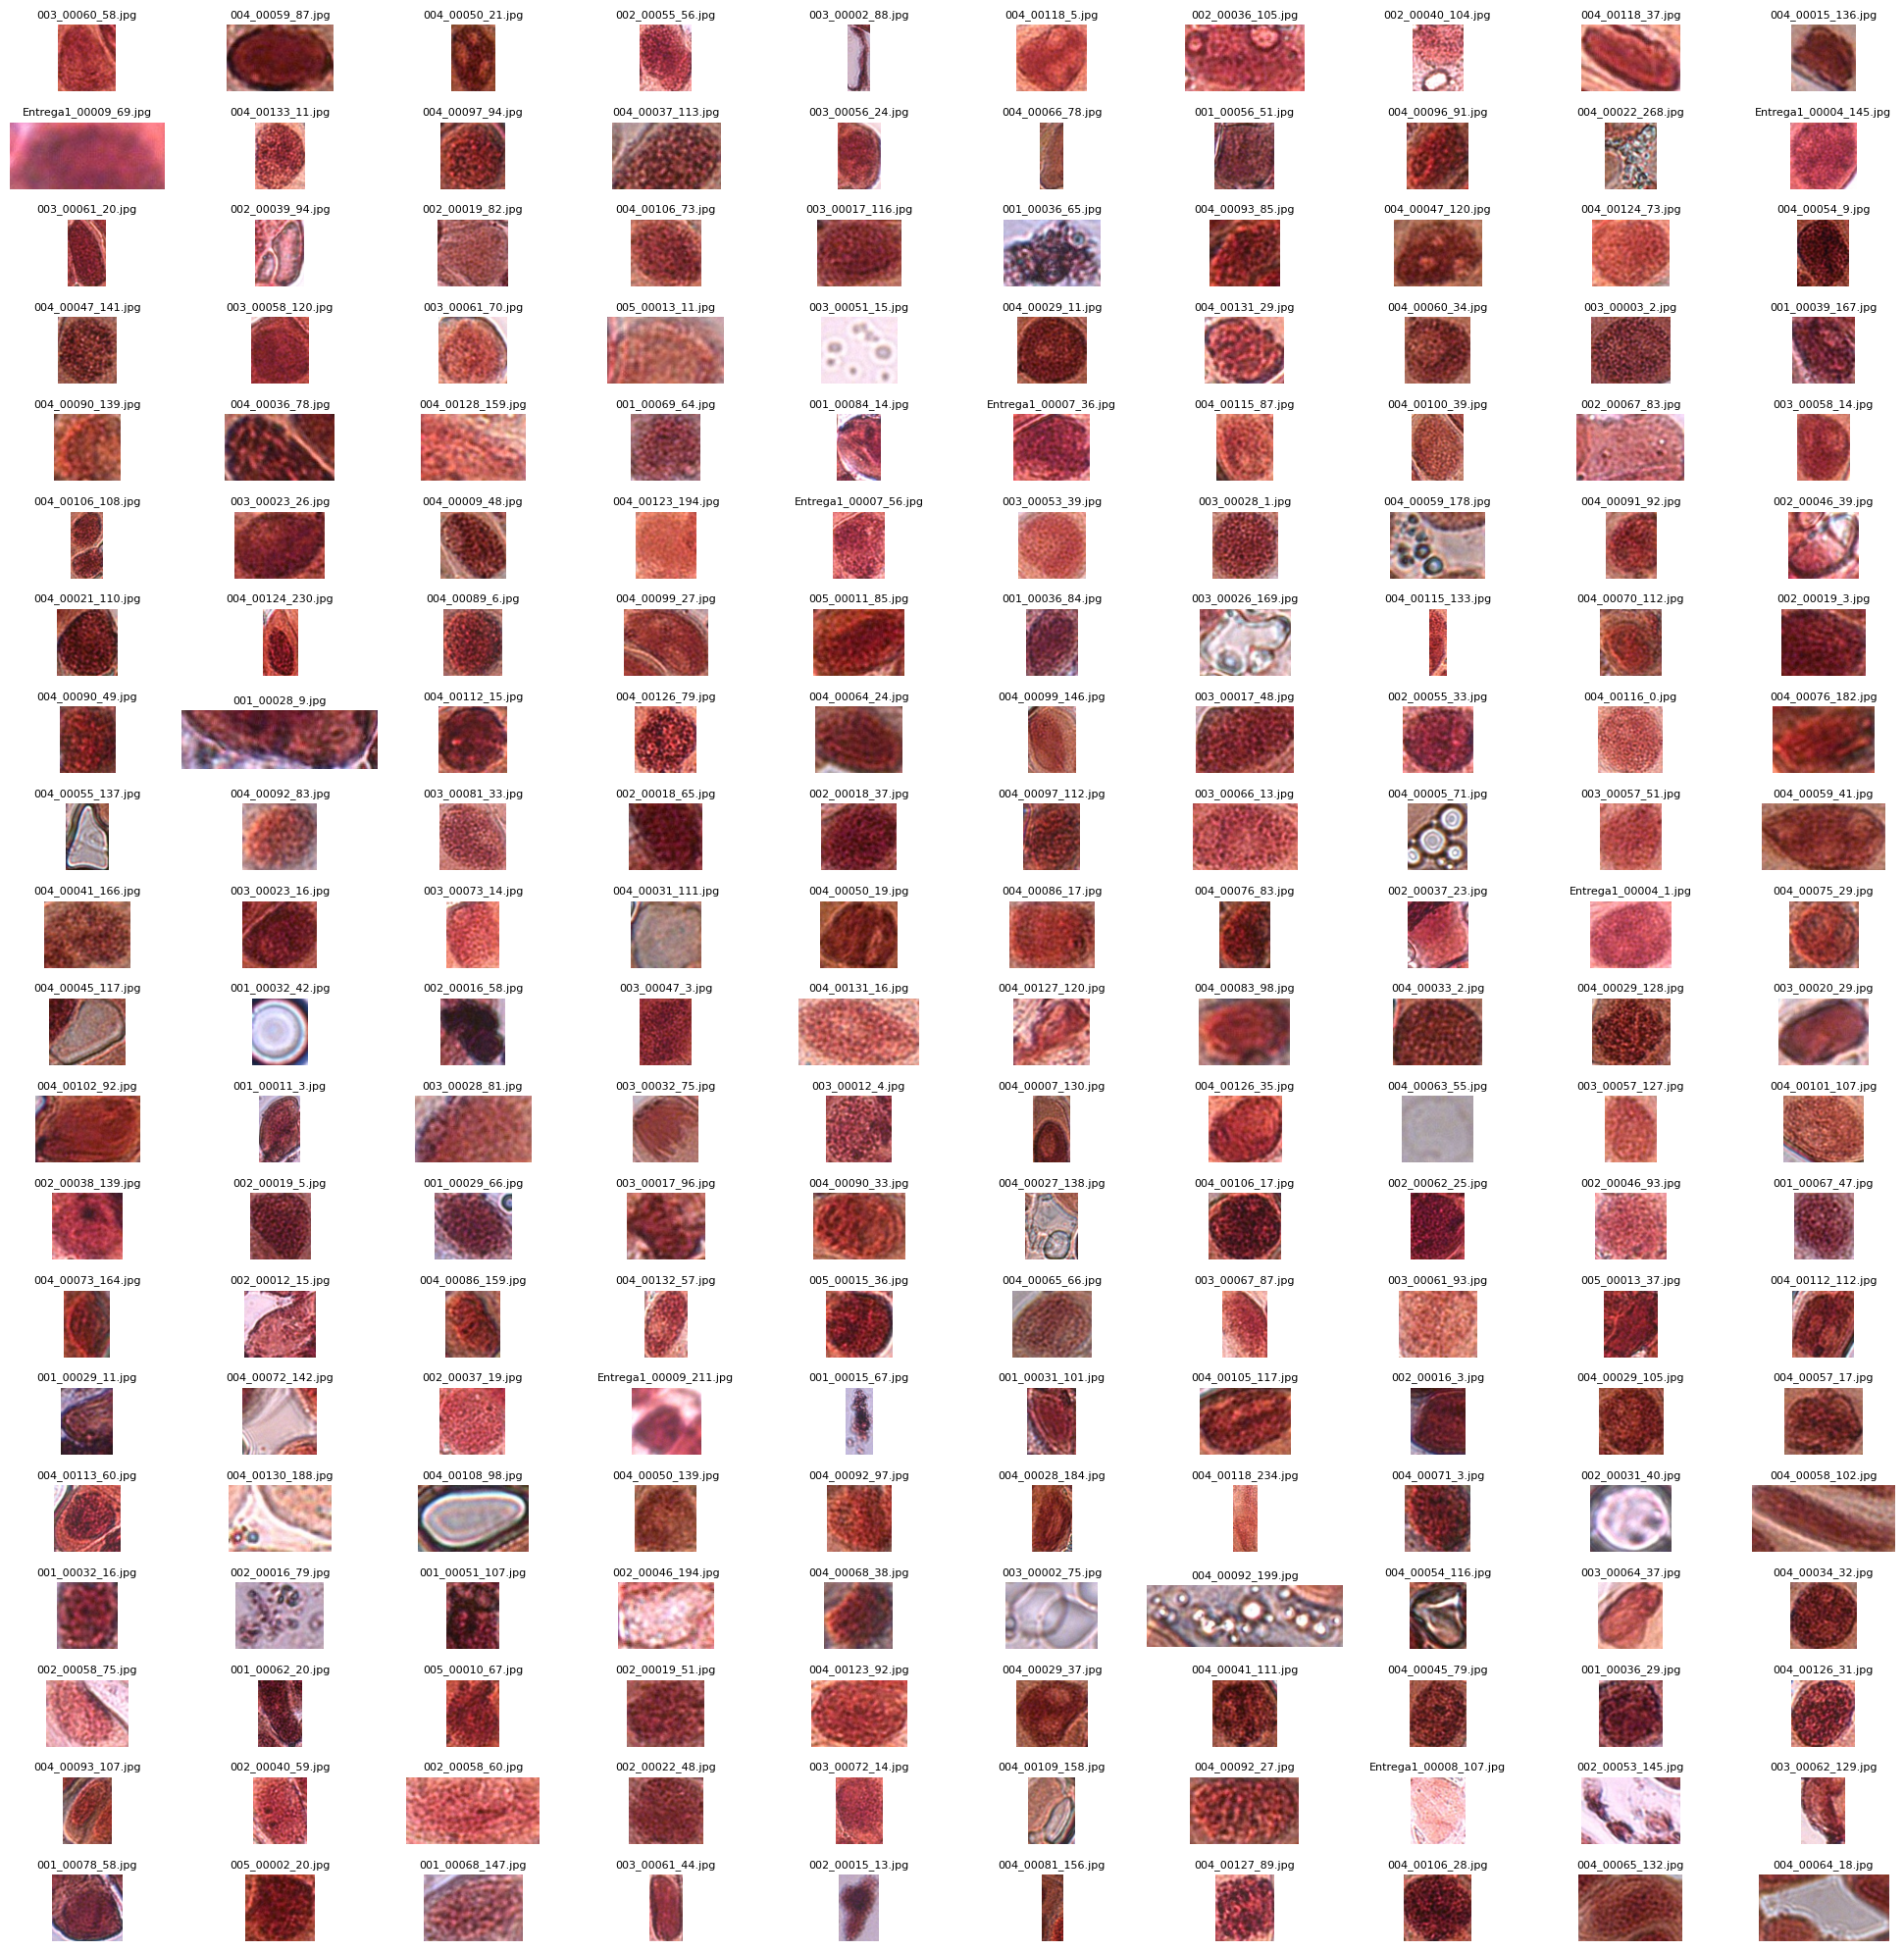

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

# Load CSV
df = pd.read_csv(OUTPUT_CSV_PATH)

# Filter area between 6000 and 30000
df_range = df[(df['area_pixeles'] >= 8000) & (df['area_pixeles'] <= 30000)]

# Sample 100 random rows
sample_df = df_range.sample(n=200)

# Image folder path
img_folder = r'C:\Users\cibei\Desktop\INA\datasets\cropped_cells_full_v3'

# Create plot
fig, axes = plt.subplots(20, 10, figsize=(20, 20))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = os.path.join(img_folder, f"{row['nombre']}")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"{row['nombre']}", fontsize=8)
    else:
        ax.axis('off')
        ax.set_title("Missing", fontsize=8)

plt.tight_layout()
plt.show()


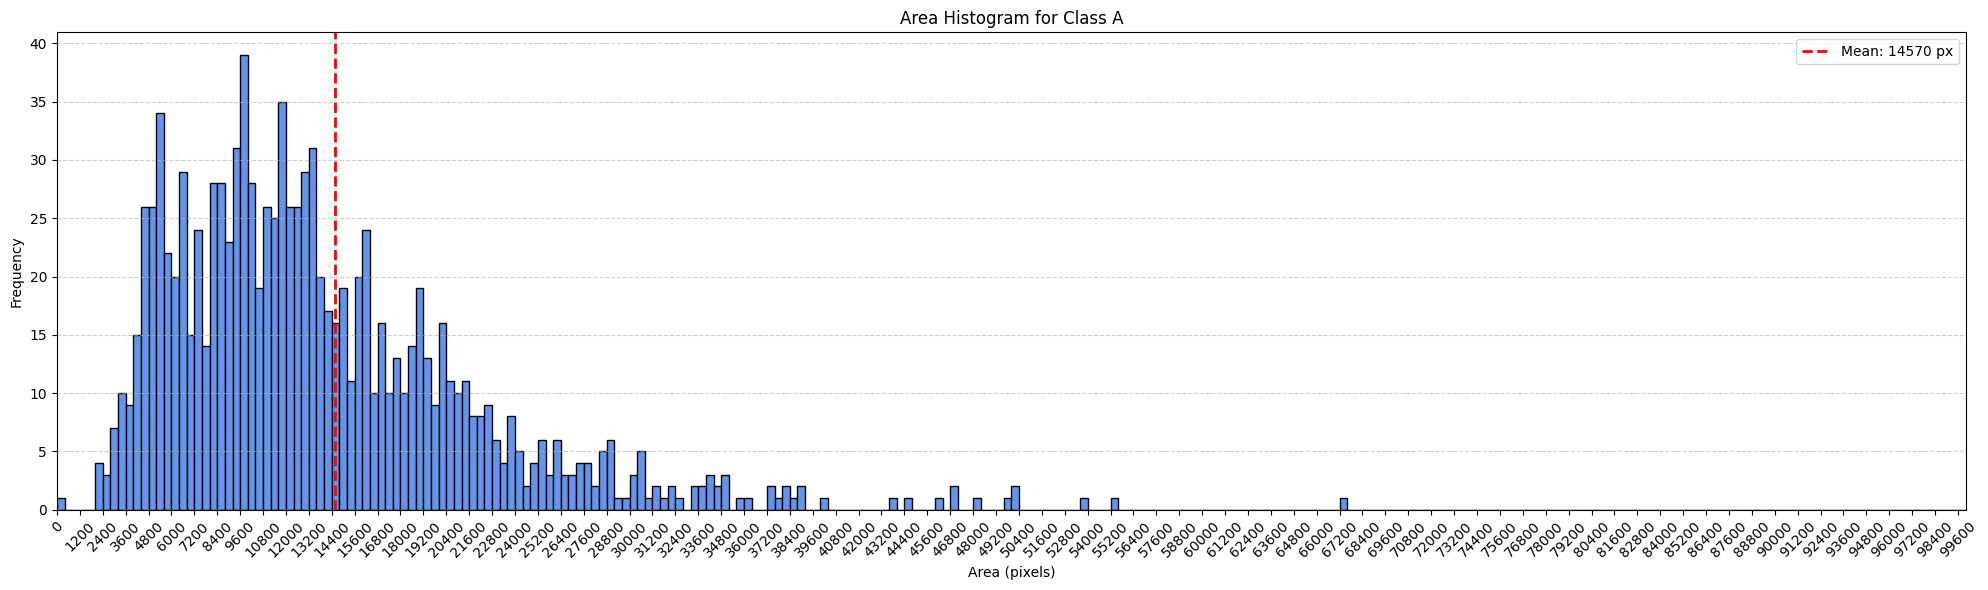

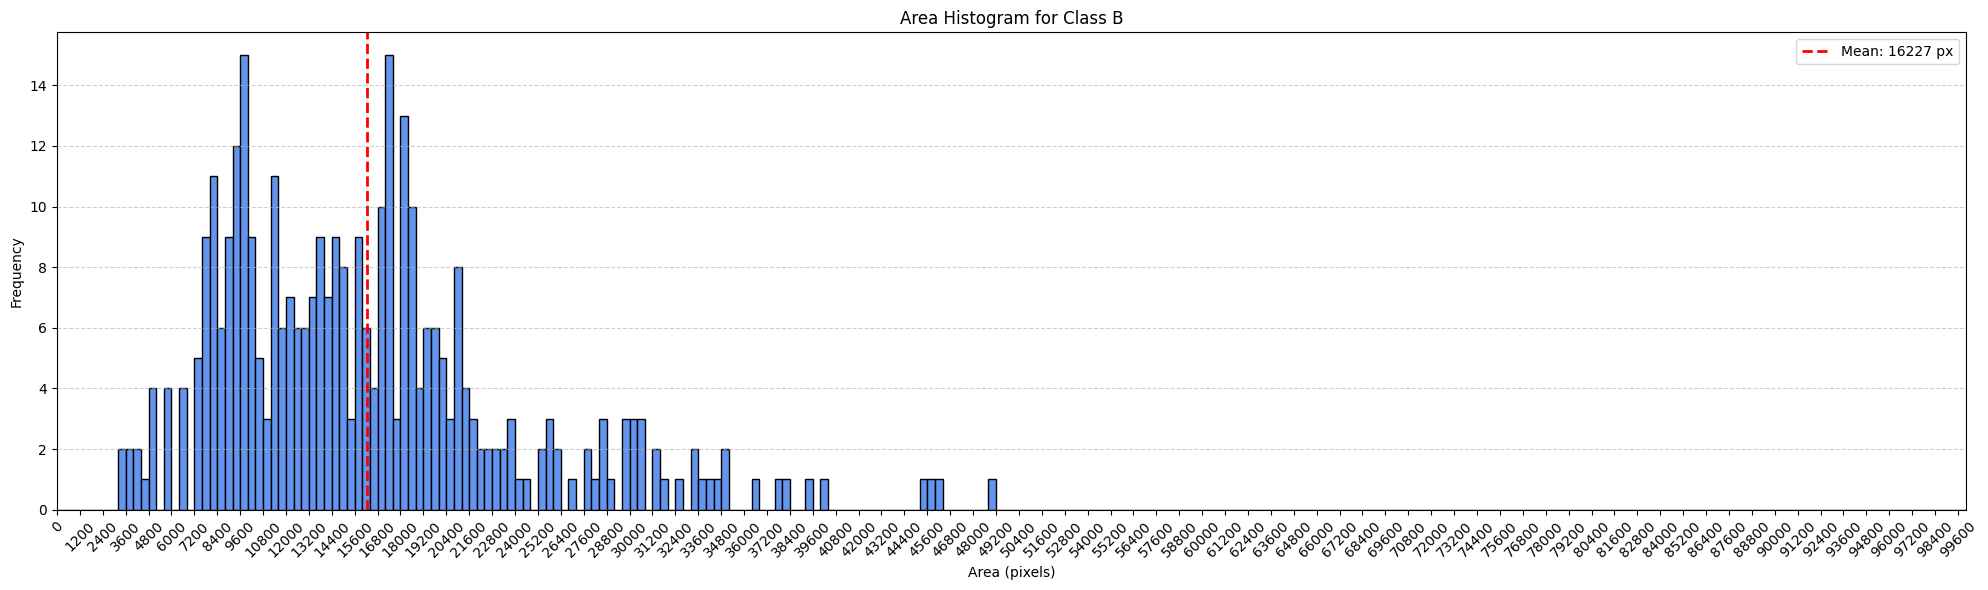

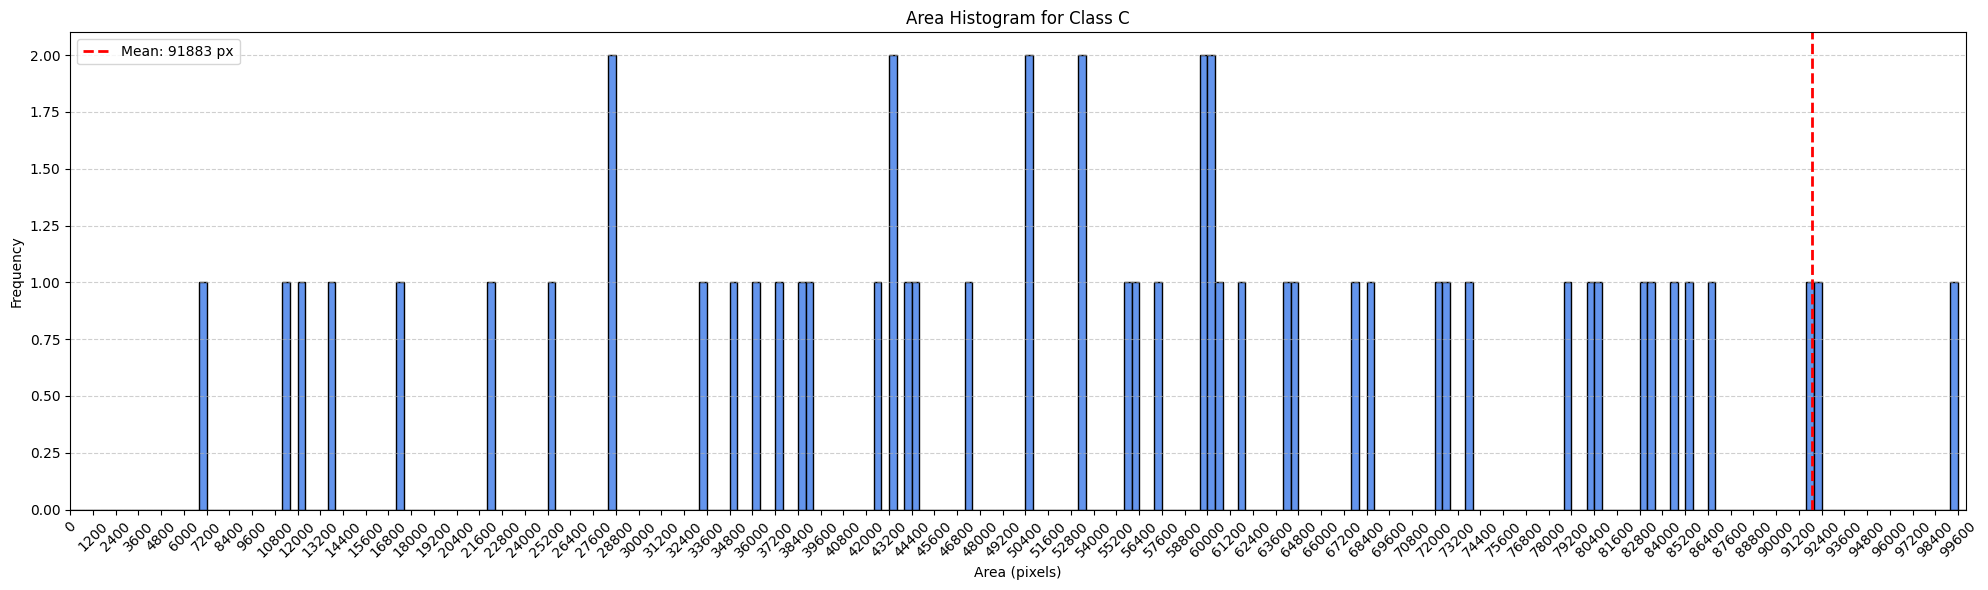

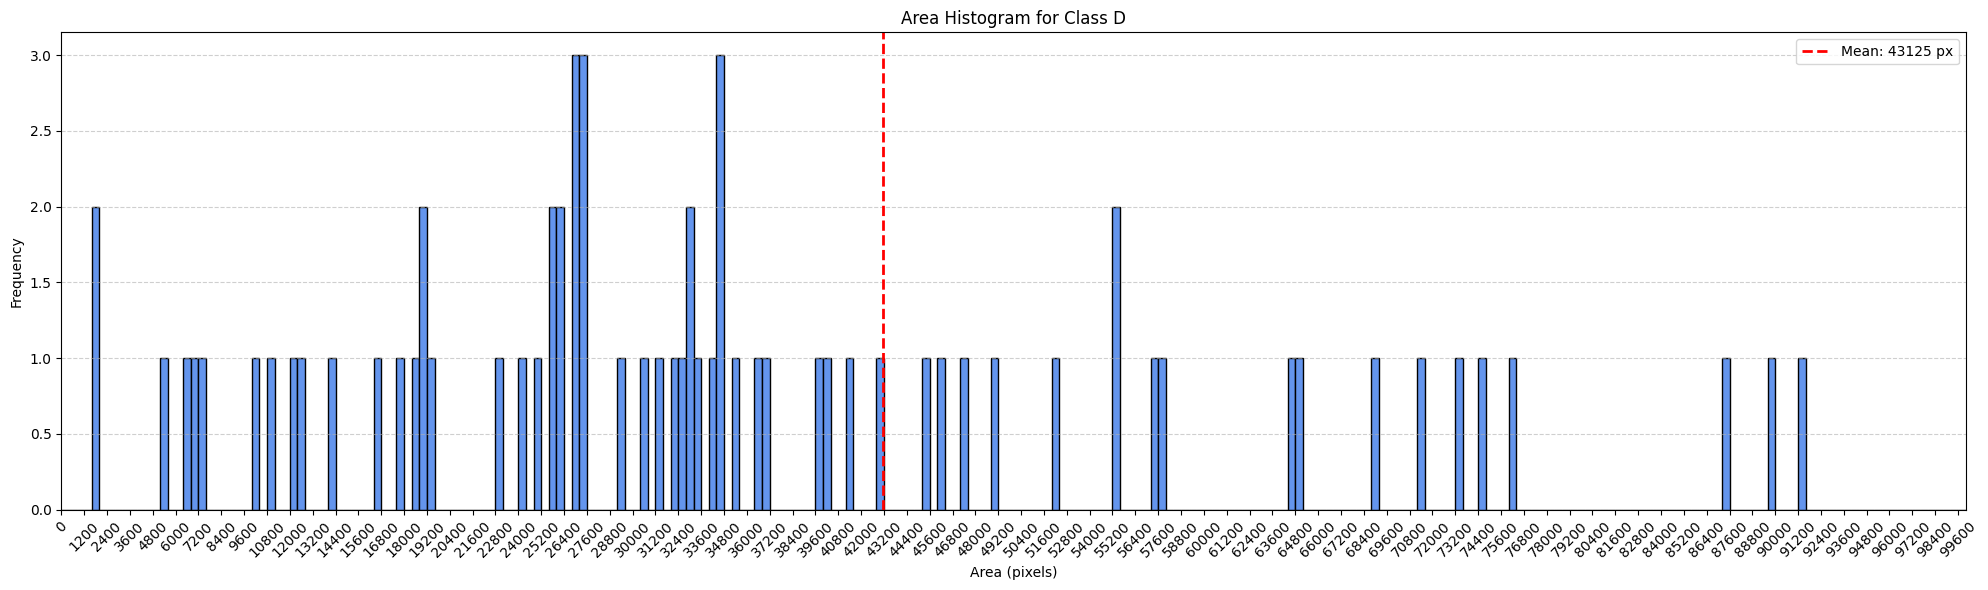

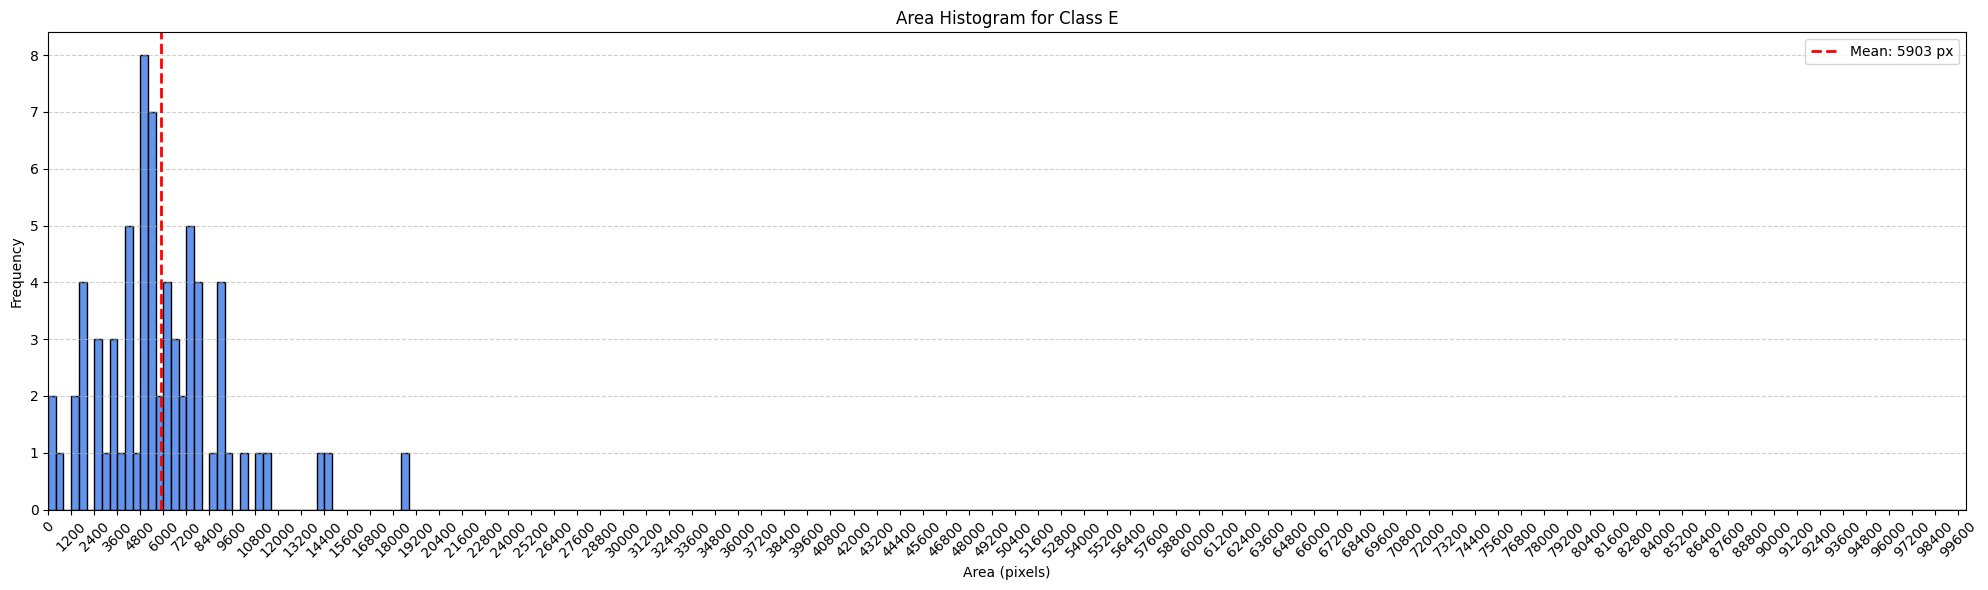

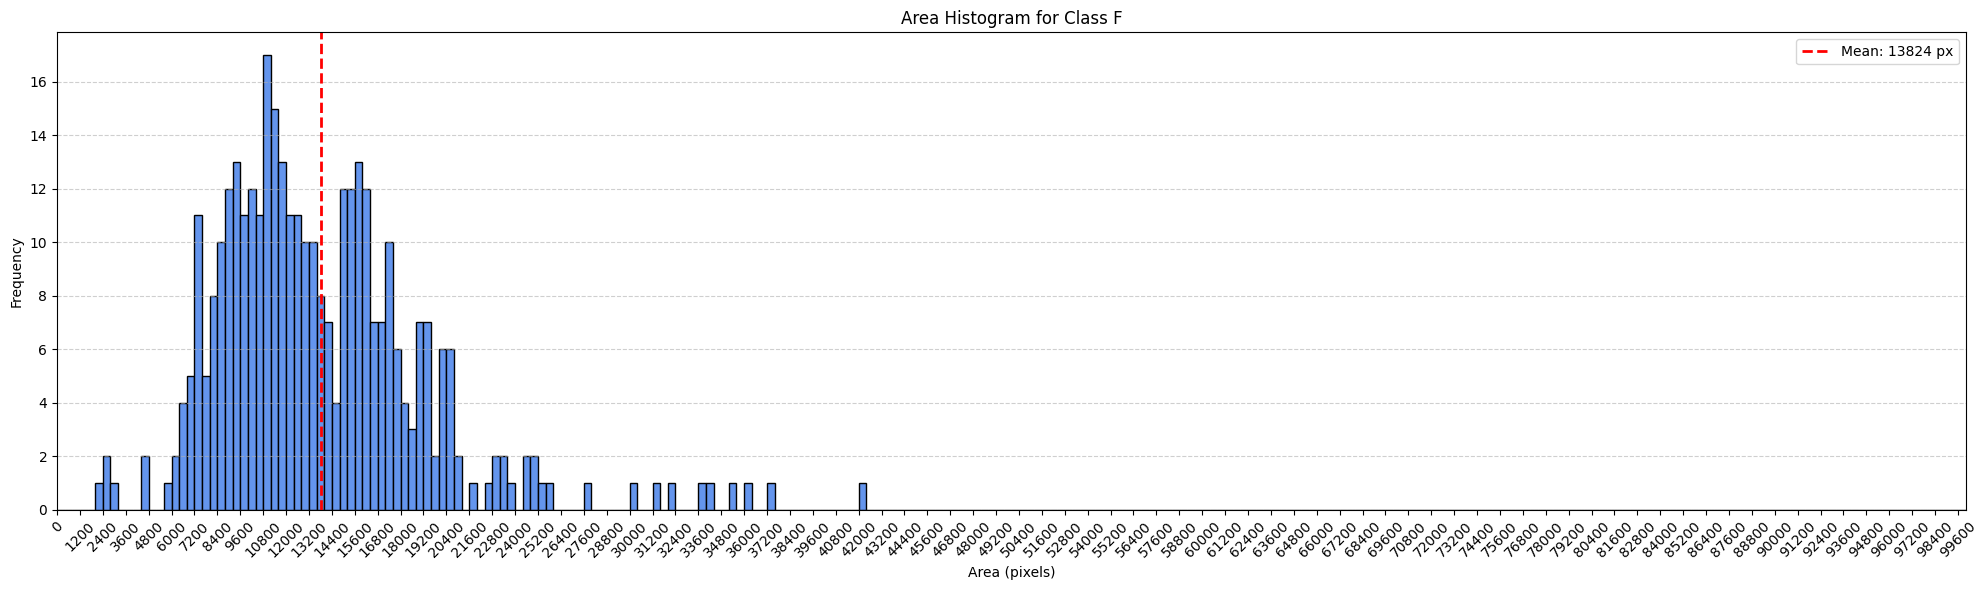

In [ ]:
# Load data
df_r = pd.read_csv(os.path.join(RESULTS_PATH, 'roboflow_annotations_areas.csv'))

# Set fixed bins and xticks
bin_start = 0
bin_end = 100_000
bin_width = 400
bins = np.arange(bin_start, bin_end + bin_width, bin_width)
xticks = np.arange(bin_start, bin_end + bin_width * 3, bin_width * 3)

# Get unique classes
classes = sorted(df_r['class'].unique())

# Plot histograms for each class
for cls in classes:
    class_df_r = df_r[df_r['class'] == cls]
    
    plt.figure(figsize=(20, 6))
    plt.hist(class_df_r['area'], bins=bins, color='cornflowerblue', edgecolor='black')
    
    # Compute and plot mean
    mean_val = class_df_r['area'].mean()

    partitions_data[cls] = AreaData(area_promedio = mean_val,
                                    lado_cuadrado = np.sqrt(mean_val),
                                    diff_area = partitions_data['ina_sam'].area_promedio -  mean_val,
                                    dif_lado = partitions_data['ina_sam'].lado_cuadrado -  np.sqrt(mean_val))

    plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean: {int(mean_val)} px")
    
    plt.title(f"Area Histogram for Class {cls}")
    plt.xlabel("Area (pixels)")
    plt.ylabel("Frequency")
    plt.xticks(xticks, rotation=45)
    plt.xlim(bin_start, bin_end)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [32]:
print(partitions_data)

{'ina_sam': AreaData(area_promedio=np.float64(16482.10973593271), lado_cuadrado=np.float64(128.38266914164353), diff_area=None, dif_lado=None), 'A': AreaData(area_promedio=np.float64(14570.998324175824), lado_cuadrado=np.float64(120.71039029087689), diff_area=np.float64(1911.1114117568868), dif_lado=np.float64(7.672278850766645)), 'B': AreaData(area_promedio=np.float64(16227.617614942528), lado_cuadrado=np.float64(127.38766665161322), diff_area=np.float64(254.49212099018223), dif_lado=np.float64(0.9950024900303163)), 'C': AreaData(area_promedio=np.float64(91883.32506578947), lado_cuadrado=np.float64(303.12262381054546), diff_area=np.float64(-75401.21532985676), dif_lado=np.float64(-174.73995466890193)), 'D': AreaData(area_promedio=np.float64(43125.977222222224), lado_cuadrado=np.float64(207.6679494342404), diff_area=np.float64(-26643.867486289513), dif_lado=np.float64(-79.28528029259687)), 'E': AreaData(area_promedio=np.float64(5903.943299999999), lado_cuadrado=np.float64(76.8371218877

In [37]:
partitions_data = {k: asdict(v) for k, v in partitions_data.items()}

In [38]:
partitions_data

{'ina_sam': {'area_promedio': np.float64(16482.10973593271),
  'lado_cuadrado': np.float64(128.38266914164353),
  'diff_area': None,
  'dif_lado': None},
 'A': {'area_promedio': np.float64(14570.998324175824),
  'lado_cuadrado': np.float64(120.71039029087689),
  'diff_area': np.float64(1911.1114117568868),
  'dif_lado': np.float64(7.672278850766645)},
 'B': {'area_promedio': np.float64(16227.617614942528),
  'lado_cuadrado': np.float64(127.38766665161322),
  'diff_area': np.float64(254.49212099018223),
  'dif_lado': np.float64(0.9950024900303163)},
 'C': {'area_promedio': np.float64(91883.32506578947),
  'lado_cuadrado': np.float64(303.12262381054546),
  'diff_area': np.float64(-75401.21532985676),
  'dif_lado': np.float64(-174.73995466890193)},
 'D': {'area_promedio': np.float64(43125.977222222224),
  'lado_cuadrado': np.float64(207.6679494342404),
  'diff_area': np.float64(-26643.867486289513),
  'dif_lado': np.float64(-79.28528029259687)},
 'E': {'area_promedio': np.float64(5903.943

In [ ]:
# Write the data to a JSON file
with open(OUTPUT_JSON_PATH, 'w') as json_file:
    json.dump(data, json_file, indent=4)